In [1]:
from sqlalchemy import create_engine
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

### IMPORT SCRAPED HOTEL-LEVEL DATA FROM POSTGRESQL

In [2]:
engine = create_engine('postgresql://sashakapralov@localhost:5432/hotels')

In [3]:
engine.table_names

<bound method Engine.table_names of Engine(postgresql://sashakapralov@localhost:5432/hotels)>

In [5]:
df = pd.read_sql_query('select * from "hotels_v2"',con=engine)

In [6]:
df.shape

(467, 27)

In [7]:
df.head()

,id,name,n_reviews,st_addr,city,state,zip_cd,excellent_ct,verygood_ct,average_ct,...,spring,summer,fall,winter,rank,highlights,prange,rooms,hclass,description
0,1,"{""\n"",""\nLoews Regency New York Hotel\n""}","{""1,355 reviews""}","{""540 Park Avenue""}","{""New York City""}",{NY},{10065-7366},{952},{162},{62},...,{(315)},{(346)},{(273)},{(286)},{#27},"{""\n"",""\nFree High Speed Internet ( WiFi )\n"",...","{""\n$379 - $794 (Based on Average Rates for a ...","{"" 379""}","{""\n"",""3.5 star — Loews Regency New York Hotel...","{""All the benefits of Midtown Manhattan at you..."
1,2,"{""\n"",""\nThe Towers of the Waldorf Astoria - T...","{""2,016 reviews""}","{""100 E 50th St""}","{""New York City""}",{NY},{10022-6844},"{""1,381""}",{245},{107},...,{(420)},{(528)},{(382)},{(500)},{#26},"{""\n"",""\nRestaurant\n"",""\n"",""\nRoom Service\n""...","{""\n$719 - $10,000 (Based on Average Rates for...","{"" 177""}","{""\n"",""5 star — The Towers of the Waldorf Asto...","{""The Waldorf Astoria New York is currently cl..."
2,3,"{""\n"",""\nLangham Place, New York, Fifth Avenue...","{""2,065 reviews""}","{""400 Fifth Avenue""}","{""New York City""}",{NY},{10018-2753},"{""1,417""}",{203},{72},...,{(432)},{(453)},{(415)},{(443)},{#25},"{""\n"",""\nFree High Speed Internet ( WiFi )\n"",...","{""\n$470 - $956 (Based on Average Rates for a ...","{"" 214""}","{""\n"",""5 star — Langham Place, New York, Fifth...","{""Gracefully complementing Manhattan's luxurio..."
3,4,"{""\n"",""\nThe Mark\n""}","{""687 reviews""}","{""Madison Avenue at 77th Street""}","{""New York City""}",{NY},{10078},{464},{87},{24},...,{(114)},{(180)},{(156)},{(139)},{#24},"{""\n"",""\nFree High Speed Internet ( WiFi )\n"",...","{""\n$503 - $1,027 (Based on Average Rates for ...","{"" 152""}","{""\n"",""5 star — The Mark 5*""}","{""The Mark is housed, as it has always been, i..."
4,5,"{""\n"",""\nThe St. Regis New York\n""}","{""633 reviews""}","{""2 East 55th Street, at Fifth Avenue""}","{""New York City""}",{NY},{10022},{448},{70},{34},...,{(124)},{(140)},{(141)},{(168)},{#30},"{""\n"",""\nFree High Speed Internet ( WiFi )\n"",...","{""\n$762 - $1,370 (Based on Average Rates for ...","{"" 229""}","{""\n"",""5 star — The St. Regis New York 5*""}","{""The St. Regis New York in midtown Manhattan ..."


### DATA CLEANING:

### HOTEL RANKS

In [8]:
df['rank'].unique()

array([u'{#27}', u'{#26}', u'{#25}', u'{#24}', u'{#30}', u'{#57}',
       u'{#90}', u'{#29}', u'{#28}', u'{#23}', u'{#60}', u'{#59}',
       u'{#58}', u'{#299}', u'{#89}', u'{#88}', u'{#87}', u'{#120}',
       u'{#119}', u'{#118}', u'{#240}', u'{#357}', u'{#117}', u'{#150}',
       u'{#149}', u'{#148}', u'{#147}', u'{#180}', u'{#179}', u'{#239}',
       u'{}', u'{#178}', u'{#177}', u'{#210}', u'{#209}', u'{#208}',
       u'{#207}', u'{#238}', u'{#237}', u'{#270}', u'{#269}', u'{#268}',
       u'{#267}', u'{#300}', u'{#441}', u'{#298}', u'{#297}', u'{#330}',
       u'{#329}', u'{#328}', u'{#327}', u'{#360}', u'{#359}', u'{#358}',
       u'{#442}', u'{#390}', u'{#389}', u'{#388}', u'{#387}', u'{#421}',
       u'{#419}', u'{#418}', u'{#417}', u'{#449}', u'{#448}', u'{#447}',
       u'{#446}', u'{#444}', u'{#445}', u'{#443}', u'{#440}', u'{#439}',
       u'{#438}', u'{#437}', u'{#436}', u'{#435}', u'{#434}', u'{#433}',
       u'{#432}', u'{#431}', u'{#430}', u'{#429}', u'{#428}', u'{#427}'

In [9]:
df['rank_num'] = df['rank'].apply(lambda x: ''.join(c for c in x if c not in '{}#'))

In [10]:
print len(df.rank_num.unique())

450


In [11]:
ranks_list = df.rank_num.unique().tolist()

In [12]:
ranks_list = [int(x) for x in ranks_list if x]

In [13]:
df['rank_num'] = df.rank_num.apply(lambda x: int(x) if x != '' else None)

In [14]:
ranks_list = sorted(ranks_list)

In [15]:
def consec_vls_chck(list):
    gaps = []
    for idx, value in enumerate(list):
        if idx < (len(list) - 1):
            if list[idx] != list[idx+1] - 1:
                gaps.append(list[idx])
    return gaps

In [16]:
consec_vls_chck(ranks_list)

[]

In [17]:
print len(ranks_list)

449


In [18]:
ranks_list

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [19]:
df.rank_num.describe()

count    449.000000
mean     225.000000
std      129.759393
min        1.000000
25%      113.000000
50%      225.000000
75%      337.000000
max      449.000000
Name: rank_num, dtype: float64

### HOTEL DESCRIPTION

In [20]:
df['description'] = df['description'].apply(lambda x: ''.join(c for c in x if c not in '{}"'))

In [21]:
df.description.head()

0    All the benefits of Midtown Manhattan at your ...
1    The Waldorf Astoria New York is currently clos...
2    Gracefully complementing Manhattan's luxurious...
3    The Mark is housed, as it has always been, in ...
4    The St. Regis New York in midtown Manhattan of...
Name: description, dtype: object

### NUMBER OF ROOMS

In [22]:
#first copy room values from prange column when they ended up there to rooms column:
df.ix[df.prange.str.contains('Number of rooms'), 'rooms'] = df.ix[df.prange.str.contains('Number of rooms'), 'prange']

In [23]:
df['rooms'] = df['rooms'].apply(lambda x: ''.join(c for c in x if c not in '{} "'))

In [24]:
df['rooms'] = df['rooms'].apply(lambda x: x.replace("Numberofrooms:,",""))

In [25]:
df.rooms.unique()

array([u'379', u'177', u'214', u'152', u'229', u'100', u'222', u'463',
       u'197', u'230', u'111', u'278', u'242', u'47', u'190', u'86',
       u'183', u'77', u'391', u'178', u'217', u'24', u'135', u'120',
       u'141', u'125', u'312', u'34', u'533', u'218', u'291', u'160',
       u'132', u'611', u'263', u'127', u'184', u'140', u'1235', u'509',
       u'110', u'273', u'199', u'101', u'208', u'64', u'92', u'50', u'56',
       u'85', u'78', u'325', u'375', u'170', u'612', u'22', u'9', u'103',
       u'57', u'44', u'45', u'65', u'4', '', u'130', u'327', u'344',
       u'150', u'118', u'250', u'310', u'251', u'145', u'355', u'159',
       u'52', u'41', u'1705', u'60', u'80', u'43', u'62', u'268', u'33',
       u'105', u'30', u'37', u'40', u'347', u'228', u'15', u'328', u'156',
       u'106', u'32', u'700', u'378', u'129', u'192', u'128', u'74', u'25',
       u'53', u'286', u'96', u'83', u'148', u'73', u'597', u'866', u'107',
       u'27', u'12', u'20', u'70', u'1013', u'38', u'317', u'

In [26]:
df['rooms_num'] = df.rooms.apply(lambda x: int(x) if x != '' else None)

In [27]:
df.rooms_num.isnull().sum()

8

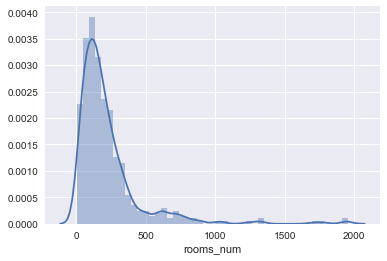

In [28]:
sns.distplot(df[df.rooms_num >= 0].rooms_num);

### PRICE RANGE

In [29]:
#first remove room values from prange column when they ended up there:
df.ix[df.prange.str.contains('Number of rooms'), 'prange'] = '{}'

In [30]:
#remove bad characters
df['prange'] = df['prange'].apply(lambda x: ''.join(c for c in x if c not in '$,"{}'))

In [31]:
#more characters removed
df['prange'] = df['prange'].apply(lambda x: x.replace("\n",""))

In [32]:
#more characters removed
df['prange'] = df['prange'].apply(lambda x: x.replace("- ",""))

In [33]:
#assign first value in range string to lower bound of the range
df['prange_low'] = df['prange'].apply(lambda x: x.split(' ')[0] if x != '' else None)

In [34]:
#assign second value in range string to upper bound of the range
df['prange_high'] = df['prange'].apply(lambda x: x.split(' ')[1] if x != '' else '')

In [35]:
#copy prange_low values to prange_high column when hotels only provided one price value, not a range:
df.ix[df.prange_high.str.contains('Based'), 'prange_high'] = df.ix[df.prange_high.str.contains('Based'), 'prange_low']

In [36]:
#convert prange_low to float
df['prange_low'] = df['prange_low'].apply(lambda x: float(x) if x != None else np.nan)

In [37]:
#convert prange_high to float
df['prange_high'] = df['prange_high'].apply(lambda x: float(x) if x != '' else np.nan)

In [38]:
df['prange_range'] = df.prange_high - df.prange_low

In [39]:
df.prange_range.isnull().sum()

29

In [40]:
df.prange_low.unique()

array([ 379.,  719.,  470.,  503.,  762.,  297.,  258.,  316.,  290.,
        265.,  274.,  237.,  231.,  184.,  405.,  261.,  298.,  368.,
        305.,  223.,  162.,  212.,  264.,  247.,  246.,  311.,  218.,
        245.,   nan,  219.,  213.,  200.,  214.,  314.,  215.,  251.,
        206.,  118.,  319.,  272.,  283.,  148.,  187.,  188.,  185.,
        226.,  192.,  186.,  157.,  166.,   76.,  175.,   77.,  199.,
         95.,  139.,  146.,   58.,  189.,  164.,  181.,  276.,  235.,
        273.,  183.,  255.,  220.,  155.,  253.,   70.,  167.,  130.,
        147.,   80.,   86.,  125.,  105.,  100.,  165.,  144.,  134.,
        150.,  135.,  714.,   69.,  182.,  156.,  108.,  325.,  178.,
        163.,  138.,  190.,  149.,  205.,  292.,  313.,  114.,  221.,
        194.,  340.,  141.,  209.,  171.,  193.,  102.,  227.,  174.,
        191.,  177.,  172.,  230.,  158.,  133.,  228.,  796.,  179.,
        511.,  420.,  173.,  196.,  268.,  275.,   90.,  197.,  869.,
        106.,  217.,

### NUMBER OF REVIEWS

In [41]:
df['n_reviews'] = df.n_reviews.apply(lambda x: ''.join(c for c in x if c not in '{}",'))

In [42]:
df.n_reviews.unique()

array([u'1355 reviews', u'2016 reviews', u'2065 reviews', u'687 reviews',
       u'633 reviews', u'407 reviews', u'2994 reviews', u'3072 reviews',
       u'3822 reviews', u'2524 reviews', u'3870 reviews', u'3394 reviews',
       u'556 reviews', u'129 reviews', u'1391 reviews', u'1039 reviews',
       u'3968 reviews', u'609 reviews', u'2916 reviews', u'1526 reviews',
       u'1101 reviews', u'545 reviews', u'1693 reviews', u'1329 reviews',
       u'1141 reviews', u'698 reviews', u'2265 reviews', u'2269 reviews',
       u'4195 reviews', '', u'4412 reviews', u'1971 reviews',
       u'678 reviews', u'4620 reviews', u'701 reviews', u'1115 reviews',
       u'532 reviews', u'2280 reviews', u'1338 reviews', u'11441 reviews',
       u'479 reviews', u'4074 reviews', u'1474 reviews', u'3 reviews',
       u'1994 reviews', u'1555 reviews', u'4039 reviews', u'756 reviews',
       u'1972 reviews', u'130 reviews', u'664 reviews', u'712 reviews',
       u'848 reviews', u'21 reviews', u'309 reviews', u'

In [43]:
df['n_reviews'] = df.n_reviews.apply(lambda x: int(x.split(' ')[0]) if x != '' else 0)

In [44]:
df.n_reviews.tail()

462     275
463     741
464    3459
465    5392
466    1270
Name: n_reviews, dtype: int64

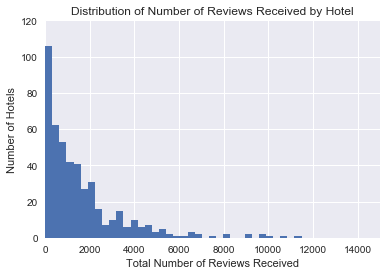

In [45]:
df.n_reviews.hist(bins=50)
plt.title("Distribution of Number of Reviews Received by Hotel")
plt.ylabel("Number of Hotels");
plt.xlabel("Total Number of Reviews Received")
plt.xlim(0,15000)
plt.ylim(0,120)
plt.show()

In [46]:
df.n_reviews.describe().T

count      467.000000
mean      1630.104925
std       1959.042842
min          0.000000
25%        384.000000
50%       1086.000000
75%       2072.000000
max      15964.000000
Name: n_reviews, dtype: float64

In [47]:
df[df.rank_num.notnull()].n_reviews.describe()

count      449.000000
mean      1695.454343
std       1970.026364
min          1.000000
25%        488.000000
50%       1125.000000
75%       2138.000000
max      15964.000000
Name: n_reviews, dtype: float64

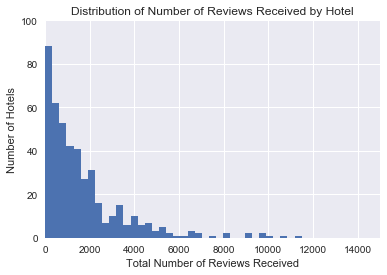

In [48]:
df[df.rank_num.notnull()].n_reviews.hist(bins=50)
plt.title("Distribution of Number of Reviews Received by Hotel")
plt.ylabel("Number of Hotels");
plt.xlabel("Total Number of Reviews Received")
plt.xlim(0,15000)
plt.ylim(0,100)
plt.show()

In [49]:
df.rank_num.describe()

count    449.000000
mean     225.000000
std      129.759393
min        1.000000
25%      113.000000
50%      225.000000
75%      337.000000
max      449.000000
Name: rank_num, dtype: float64

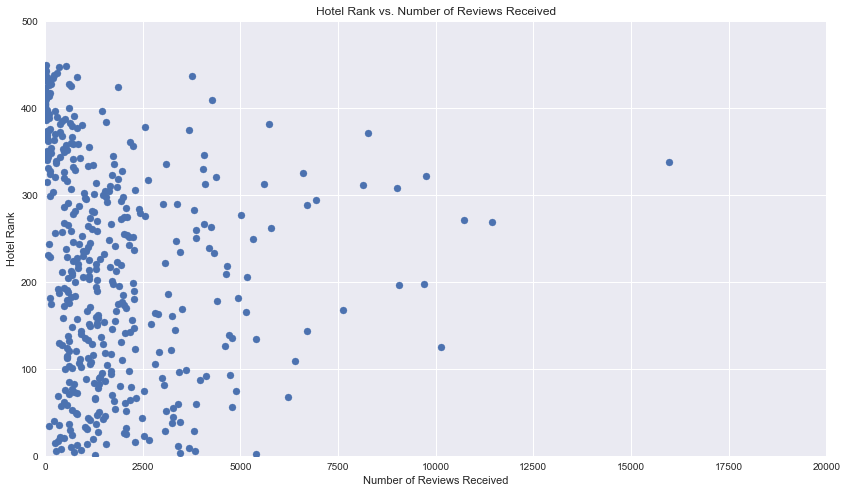

In [50]:
plt.figure(figsize = (14,8))
plt.scatter(df.n_reviews, df.rank_num)
plt.title("Hotel Rank vs. Number of Reviews Received")
plt.ylabel("Hotel Rank");
plt.xlabel("Number of Reviews Received")
plt.xlim(0,20000)
plt.ylim(0,500)
plt.show()

In [51]:
#total number of reviews across all hotels
df.n_reviews.sum()

761259

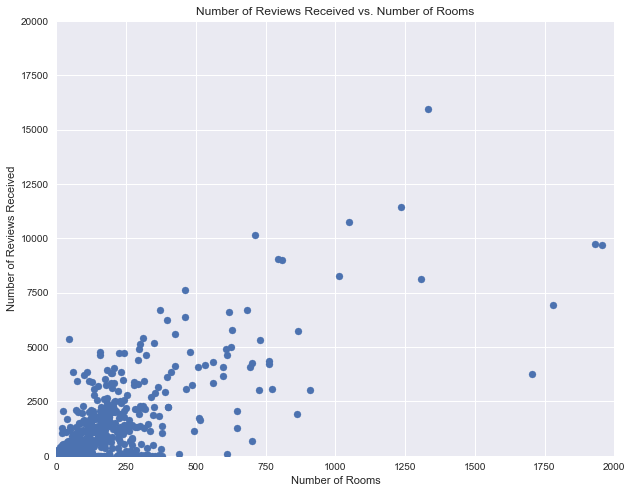

In [52]:
plt.figure(figsize = (10,8))
plt.scatter(df.rooms_num, df.n_reviews)
plt.title("Number of Reviews Received vs. Number of Rooms")
plt.ylabel("Number of Reviews Received");
plt.xlabel("Number of Rooms")
plt.xlim(0,2000)
plt.ylim(0,20000)
plt.show()

In [53]:
df_name_rank_reviews = df[['name','rank_num','n_reviews']]

In [54]:
df_name_rank_reviews.to_csv('names_ranks_review_cts.csv')

### HOTEL CLASS

In [55]:
df['hclass'] = df['hclass'].apply(lambda x: ''.join(c for c in x if c not in '{},"'))

In [56]:
df.hclass.unique()

array([u'\n3.5 star \u2014 Loews Regency New York Hotel 3.5*',
       u'\n5 star \u2014 The Towers of the Waldorf Astoria - TEMPORARILY CLOSED 5*',
       u'\n5 star \u2014 Langham Place New York Fifth Avenue 5*',
       u'\n5 star \u2014 The Mark 5*',
       u'\n5 star \u2014 The St. Regis New York 5*',
       u'\n5 star \u2014 Smyth a Thompson Hotel 5*',
       u'\n4.5 star \u2014 Kimpton Ink48 Hotel 4.5*',
       u'\n5 star \u2014 Conrad New York 5*',
       u'\n5 star \u2014 Refinery Hotel 5*',
       u'\n4 star \u2014 citizenM New York Times Square 4*',
       u'\n4.5 star \u2014 Sanctuary Hotel New York 4.5*',
       u'\n4 star \u2014 Hotel Beacon 4*',
       u'\n3.5 star \u2014 Residence Inn New York Downtown Manhattan/World Trade Center Area 3.5*',
       u'\n3 star \u2014 Hotel Shocard at Times Square 3*',
       u'\n4 star \u2014 Gramercy Park Hotel 4*',
       u'\n4 star \u2014 Cassa Hotel Times Square 4*',
       u'\n3 star \u2014 Hotel Metro 3*',
       u'\n4 star \u2014 C

In [57]:
df['hclass'] = df['hclass'].apply(lambda x: ''.join(c for c in x if c not in '\n'))

In [58]:
df.hclass.unique()

array([u'3.5 star \u2014 Loews Regency New York Hotel 3.5*',
       u'5 star \u2014 The Towers of the Waldorf Astoria - TEMPORARILY CLOSED 5*',
       u'5 star \u2014 Langham Place New York Fifth Avenue 5*',
       u'5 star \u2014 The Mark 5*',
       u'5 star \u2014 The St. Regis New York 5*',
       u'5 star \u2014 Smyth a Thompson Hotel 5*',
       u'4.5 star \u2014 Kimpton Ink48 Hotel 4.5*',
       u'5 star \u2014 Conrad New York 5*',
       u'5 star \u2014 Refinery Hotel 5*',
       u'4 star \u2014 citizenM New York Times Square 4*',
       u'4.5 star \u2014 Sanctuary Hotel New York 4.5*',
       u'4 star \u2014 Hotel Beacon 4*',
       u'3.5 star \u2014 Residence Inn New York Downtown Manhattan/World Trade Center Area 3.5*',
       u'3 star \u2014 Hotel Shocard at Times Square 3*',
       u'4 star \u2014 Gramercy Park Hotel 4*',
       u'4 star \u2014 Cassa Hotel Times Square 4*',
       u'3 star \u2014 Hotel Metro 3*', u'4 star \u2014 Chambers Hotel 4*',
       u'5 star \u2014 T

In [59]:
df['hclass_num'] = df['hclass'].apply(lambda x: float(x.split()[0]) if x != '' else None)

In [60]:
df.hclass_num.unique()

array([ 3.5,  5. ,  4.5,  4. ,  3. ,  nan,  2. ,  2.5,  1.5,  1. ])

In [61]:
df.hclass_num.value_counts(dropna=False)

 4.0    135
 3.0     88
 3.5     63
 4.5     50
NaN      41
 5.0     41
 2.5     27
 2.0     17
 1.0      3
 1.5      2
Name: hclass_num, dtype: int64

In [62]:
df.columns

Index([          u'id',         u'name',    u'n_reviews',      u'st_addr',
               u'city',        u'state',       u'zip_cd', u'excellent_ct',
        u'verygood_ct',   u'average_ct',      u'poor_ct',  u'terrible_ct',
           u'families',      u'couples',         u'solo',     u'business',
            u'friends',       u'spring',       u'summer',         u'fall',
             u'winter',         u'rank',   u'highlights',       u'prange',
              u'rooms',       u'hclass',  u'description',     u'rank_num',
          u'rooms_num',   u'prange_low',  u'prange_high', u'prange_range',
         u'hclass_num'],
      dtype='object')

### NAME OF HOTEL

In [63]:
df.name.head()

0            {"\n","\nLoews Regency New York Hotel\n"}
1    {"\n","\nThe Towers of the Waldorf Astoria - T...
2    {"\n","\nLangham Place, New York, Fifth Avenue...
3                                {"\n","\nThe Mark\n"}
4                  {"\n","\nThe St. Regis New York\n"}
Name: name, dtype: object

In [64]:
df['name'] = df['name'].apply(lambda x: ''.join(c for c in x if c not in '{},"'))

In [65]:
df.name.head()

0                   \n\nLoews Regency New York Hotel\n
1    \n\nThe Towers of the Waldorf Astoria - TEMPOR...
2            \n\nLangham Place New York Fifth Avenue\n
3                                       \n\nThe Mark\n
4                         \n\nThe St. Regis New York\n
Name: name, dtype: object

In [66]:
df['name'] = df['name'].apply(lambda x: ''.join(c for c in x if c not in '\n'))

In [67]:
df.name.unique()

array([u'Loews Regency New York Hotel',
       u'The Towers of the Waldorf Astoria - TEMPORARILY CLOSED',
       u'Langham Place New York Fifth Avenue', u'The Mark',
       u'The St. Regis New York', u'Smyth a Thompson Hotel',
       u'Kimpton Ink48 Hotel', u'Conrad New York', u'Refinery Hotel',
       u'citizenM New York Times Square', u'Sanctuary Hotel New York',
       u'Hotel Beacon',
       u'Residence Inn New York Downtown Manhattan/World Trade Center Area',
       u'Hotel Shocard at Times Square', u'Gramercy Park Hotel',
       u'Cassa Hotel Times Square', u'Hotel Metro', u'Chambers Hotel',
       u'Trump SoHo New York', u'Hyatt Union Square New York',
       u'W New York - Downtown', u'Da Vinci Hotel',
       u'The Jewel facing Rockefeller Center', u'The Blakely New York',
       u'SIXTY LES', u'The Premier New York Times Square',
       u'Marriott Vacation Club Pulse New York City',
       u'Renaissance New York Times Square Hotel', u'Hotel Mulberry',
       u'Radisson Martini

### ADDRESS FIELDS

In [68]:
df['st_addr'] = df['st_addr'].apply(lambda x: ''.join(c for c in x if c not in '{}"'))

In [69]:
df.st_addr.head()

0                        540 Park Avenue
1                          100 E 50th St
2                       400 Fifth Avenue
3          Madison Avenue at 77th Street
4    2 East 55th Street, at Fifth Avenue
Name: st_addr, dtype: object

In [70]:
df['city'] = df['city'].apply(lambda x: ''.join(c for c in x if c not in '{}"'))

In [71]:
df.city.head()

0    New York City
1    New York City
2    New York City
3    New York City
4    New York City
Name: city, dtype: object

In [72]:
df['state'] = df['state'].apply(lambda x: ''.join(c for c in x if c not in '{}'))

In [73]:
df.state.value_counts()

NY    467
Name: state, dtype: int64

In [74]:
df['zip_cd'] = df['zip_cd'].apply(lambda x: ''.join(c for c in x if c not in '{}"'))

In [75]:
#clean zip code value with NY in the text
df['zip_cd'] = df['zip_cd'].apply(lambda x: ''.join(c for c in x if c not in 'NY '))

In [76]:
df.zip_cd.head()

0    10065-7366
1    10022-6844
2    10018-2753
3         10078
4         10022
Name: zip_cd, dtype: object

In [77]:
df['zip_5'] = df.zip_cd.apply(lambda x: x[:5])

In [78]:
df.zip_5.unique()

array([u'10065', u'10022', u'10018', u'10078', u'10007', u'10036',
       u'10282', u'10019', u'10023', u'10038', u'10010', u'10001',
       u'10013', u'10003', u'10006', u'10002', u'10017', u'10024',
       u'10014', u'10025', u'10012', u'10016', u'10011', u'12855',
       u'10004', u'10029', u'07001', '', u'10033', u'11354', u'10028',
       u'10005', u'11232', u'10128', u'10032', u'10021', u'10027'], dtype=object)

In [79]:
df.loc[df['zip_5'] == '']

,id,name,n_reviews,st_addr,city,state,zip_cd,excellent_ct,verygood_ct,average_ct,...,rooms,hclass,description,rank_num,rooms_num,prange_low,prange_high,prange_range,hclass_num,zip_5
83,82,Elk Hotel,4,360 42nd Street,New York City,NY,,{0},{1},{0},...,50,,,446.0,50.0,NaN,NaN,NaN,NaN,


In [80]:
df.loc[df['name'] == 'Elk Hotel','zip_cd'] = '10036'

In [81]:
df.loc[df['name'] == 'Elk Hotel','zip_5'] = '10036'

In [82]:
df.loc[df['name'] == 'Elk Hotel']

,id,name,n_reviews,st_addr,city,state,zip_cd,excellent_ct,verygood_ct,average_ct,...,rooms,hclass,description,rank_num,rooms_num,prange_low,prange_high,prange_range,hclass_num,zip_5
83,82,Elk Hotel,4,360 42nd Street,New York City,NY,10036,{0},{1},{0},...,50,,,446.0,50.0,NaN,NaN,NaN,NaN,10036


In [83]:
df.loc[~df['zip_5'].str.contains('10')]

,id,name,n_reviews,st_addr,city,state,zip_cd,excellent_ct,verygood_ct,average_ct,...,rooms,hclass,description,rank_num,rooms_num,prange_low,prange_high,prange_range,hclass_num,zip_5
59,57,Beacon Light Motel,1,Route 9,New York City,NY,12855,{0},{0},{1},...,9,,,421.0,9.0,NaN,NaN,NaN,NaN,12855
78,77,Hotel Henri,0,37 West 24th street,New York City,NY,07001,{},{},{},...,118,4 star — Hotel Henri 4*,Hotel Henri is Manhattan's newest boutique exp...,NaN,118.0,183.0,416.0,233.0,4.0,07001
95,96,Flushing Motel,5,3450 Linden Pl,New York City,NY,11354,{0},{1},{0},...,4,,,432.0,4.0,105.0,151.0,46.0,NaN,11354
131,132,Comfort Inn Sunset Park / Park Slope,35,353 38th St,New York City,NY,11232-2511,{6},{10},{3},...,,2 star — Comfort Inn Sunset Park / Park Slope 2*,,392.0,NaN,178.0,183.0,5.0,2.0,11232


In [84]:
#remove hotels above (Comfort Inn Sunset Park is permanently closed)
df = df[df['zip_5'].str.contains('10')]

In [85]:
df.zip_5.unique()

array([u'10065', u'10022', u'10018', u'10078', u'10007', u'10036',
       u'10282', u'10019', u'10023', u'10038', u'10010', u'10001',
       u'10013', u'10003', u'10006', u'10002', u'10017', u'10024',
       u'10014', u'10025', u'10012', u'10016', u'10011', u'10004',
       u'10029', u'10033', u'10028', u'10005', u'10128', u'10032',
       u'10021', u'10027'], dtype=object)

In [86]:
df['full_addr'] = df.st_addr + ", " + df.city + ", " + df.state + " " + df.zip_5

In [87]:
df.full_addr.head(10)

0             540 Park Avenue, New York City, NY 10065
1               100 E 50th St, New York City, NY 10022
2            400 Fifth Avenue, New York City, NY 10018
3    Madison Avenue at 77th Street, New York City, ...
4    2 East 55th Street, at Fifth Avenue, New York ...
5            85 West Broadway, New York City, NY 10007
6     653 11th Avenue at 48th, New York City, NY 10036
7        102 North End Avenue, New York City, NY 10282
8         63 West 38th Street, New York City, NY 10018
9        218 West 50th Street, New York City, NY 10019
Name: full_addr, dtype: object

In [88]:
df.loc[df['full_addr'].str.contains('at ')][['name','full_addr']]

,name,full_addr
3,The Mark,"Madison Avenue at 77th Street, New York City, ..."
4,The St. Regis New York,"2 East 55th Street, at Fifth Avenue, New York ..."
6,Kimpton Ink48 Hotel,"653 11th Avenue at 48th, New York City, NY 10036"
11,Hotel Beacon,"2130 Broadway at 75th Street, New York City, N..."
42,W New York - Times Square,"1567 Broadway at 47th St, New York City, NY 10036"
90,Hotel Pennsylvania New York,"401 Seventh Avenue at 33rd Street, New York Ci..."
93,Riff Chelsea,"300 W 30th St at 8th Ave, New York City, NY 10001"
148,The Roosevelt Hotel,"45 East 45th Street at Madison Avenue, New Yor..."
183,Wellington Hotel,"871 7th Avenue at W 55th St, New York City, NY..."
213,The Manhattan at Times Square Hotel,"790 7th Avenue at 51st Street, New York City, ..."


In [89]:
df.loc[df['name'] == 'The Mark','full_addr'] = '25 E 77th St, New York, NY 10075'

In [90]:
df.loc[df['name'] == 'The St. Regis New York','full_addr'].str.replace(', at Fifth Avenue','')

4    2 East 55th Street, New York City, NY 10022
Name: full_addr, dtype: object

In [91]:
df.loc[df['name'] == 'The St. Regis New York','full_addr'] = df.loc[df['name'] == 'The St. Regis New York','full_addr'].str.replace(', at Fifth Avenue','')

In [92]:
df.ix[4]['full_addr']

u'2 East 55th Street, New York City, NY 10022'

In [93]:
df.loc[df['name'] == 'Kimpton Ink48 Hotel','full_addr']

6    653 11th Avenue at 48th, New York City, NY 10036
Name: full_addr, dtype: object

In [94]:
df.loc[df['name'] == 'Kimpton Ink48 Hotel','full_addr'] = df.loc[df['name'] == 'Kimpton Ink48 Hotel','full_addr'].str.replace(' at 48th','')

In [95]:
df.ix[6]['full_addr']

u'653 11th Avenue, New York City, NY 10036'

In [96]:
df.loc[df['name'] == 'Hotel Beacon','full_addr']

11    2130 Broadway at 75th Street, New York City, N...
Name: full_addr, dtype: object

In [97]:
df.loc[df['name'] == 'Hotel Beacon','full_addr'] = df.loc[df['name'] == 'Hotel Beacon','full_addr'].str.replace(' at 75th Street','')

In [98]:
df.ix[11]['full_addr']

u'2130 Broadway, New York City, NY 10023'

In [99]:
df.loc[df['name'] == 'W New York - Times Square','full_addr']

42    1567 Broadway at 47th St, New York City, NY 10036
Name: full_addr, dtype: object

In [100]:
df.loc[df['name'] == 'W New York - Times Square','full_addr'] = df.loc[df['name'] == 'W New York - Times Square','full_addr'].str.replace(' at 47th St','')

In [101]:
df.ix[42]['full_addr']

u'1567 Broadway, New York City, NY 10036'

In [102]:
df.loc[df['name'] == 'Hotel Pennsylvania New York','full_addr']

90    401 Seventh Avenue at 33rd Street, New York Ci...
Name: full_addr, dtype: object

In [103]:
df.loc[df['name'] == 'Hotel Pennsylvania New York','full_addr'] = df.loc[df['name'] == 'Hotel Pennsylvania New York','full_addr'].str.replace(' at 33rd Street','')

In [104]:
df.ix[90]['full_addr']

u'401 Seventh Avenue, New York City, NY 10001'

In [105]:
df.loc[df['name'] == 'Riff Chelsea','full_addr']

93    300 W 30th St at 8th Ave, New York City, NY 10001
Name: full_addr, dtype: object

In [106]:
df.loc[df['name'] == 'Riff Chelsea','full_addr'] = df.loc[df['name'] == 'Riff Chelsea','full_addr'].str.replace(' at 8th Ave','')

In [107]:
df.ix[93]['full_addr']

u'300 W 30th St, New York City, NY 10001'

In [108]:
df.loc[df['name'] == 'The Roosevelt Hotel','full_addr']

148    45 East 45th Street at Madison Avenue, New Yor...
Name: full_addr, dtype: object

In [109]:
df.loc[df['name'] == 'The Roosevelt Hotel','full_addr'] = df.loc[df['name'] == 'The Roosevelt Hotel','full_addr'].str.replace(' at Madison Avenue','')

In [110]:
df.ix[148]['full_addr']

u'45 East 45th Street, New York City, NY 10017'

In [111]:
df.loc[df['name'] == 'Wellington Hotel','full_addr']

183    871 7th Avenue at W 55th St, New York City, NY...
Name: full_addr, dtype: object

In [112]:
df.loc[df['name'] == 'Wellington Hotel','full_addr'] = df.loc[df['name'] == 'Wellington Hotel','full_addr'].str.replace(' at W 55th St','')

In [113]:
df.ix[183]['full_addr']

u'871 7th Avenue, New York City, NY 10019'

In [114]:
df.loc[df['name'] == 'The Manhattan at Times Square Hotel','full_addr']

213    790 7th Avenue at 51st Street, New York City, ...
Name: full_addr, dtype: object

In [115]:
df.loc[df['name'] == 'The Manhattan at Times Square Hotel','full_addr'] = df.loc[df['name'] == 'The Manhattan at Times Square Hotel','full_addr'].str.replace(' at 51st Street','')

In [116]:
df.ix[213]['full_addr']

u'790 7th Avenue, New York City, NY 10019'

In [117]:
df.loc[df['name'] == 'Park Central Hotel New York','full_addr']

235    870 Seventh Avenue at 56th Street, New York Ci...
Name: full_addr, dtype: object

In [118]:
df.loc[df['name'] == 'Park Central Hotel New York','full_addr'] = df.loc[df['name'] == 'Park Central Hotel New York','full_addr'].str.replace(' at 56th Street','')

In [119]:
df.ix[235]['full_addr']

u'870 Seventh Avenue, New York City, NY 10019'

In [120]:
df.loc[df['name'] == 'The Plaza','full_addr']

382    Fifth Avenue at Central Park South, New York C...
Name: full_addr, dtype: object

In [121]:
df.loc[df['name'] == 'The Plaza','full_addr'] = '768 5th Ave, New York, NY 10019'

In [122]:
df.ix[382]['full_addr']

'768 5th Ave, New York, NY 10019'

In [123]:
df.loc[df['name'] == 'Mandarin Oriental New York','full_addr']

424    80 Columbus Circle at 60th Street, New York Ci...
Name: full_addr, dtype: object

In [124]:
df.loc[df['name'] == 'Mandarin Oriental New York','full_addr'] = df.loc[df['name'] == 'Mandarin Oriental New York','full_addr'].str.replace(' at 60th Street','')

In [125]:
df.ix[424]['full_addr']

u'80 Columbus Circle, New York City, NY 10023'

In [126]:
df.loc[df['name'] == 'The Peninsula New York','full_addr']

444    700 Fifth Avenue at 55th Street, New York City...
Name: full_addr, dtype: object

In [127]:
df.loc[df['name'] == 'The Peninsula New York','full_addr'] = df.loc[df['name'] == 'The Peninsula New York','full_addr'].str.replace(' at 55th Street','')

In [128]:
df.ix[444]['full_addr']

u'700 Fifth Avenue, New York City, NY 10019'

In [129]:
df.loc[df['name'] == 'The Pierre A Taj Hotel New York','full_addr']

453    2 East 61st Street at Fifth Avenue, New York C...
Name: full_addr, dtype: object

In [130]:
df.loc[df['name'] == 'The Pierre A Taj Hotel New York','full_addr'] = df.loc[df['name'] == 'The Pierre A Taj Hotel New York','full_addr'].str.replace(' at Fifth Avenue','')

In [131]:
df.ix[453]['full_addr']

u'2 East 61st Street, New York City, NY 10065'

In [132]:
df.full_addr.isnull().sum()

0

In [133]:
df.reset_index(inplace=True)

In [134]:
df.shape

(463, 36)

### GEOCODING

In [135]:
import geocoder

In [136]:
def long_lat(address):
    g = geocoder.google(address)
    longit = g.lng
    latit = g.lat
    return longit, latit

In [137]:
df['longitude'], df['latitude'] = zip(*df['full_addr'].apply(lambda x: long_lat(x)))

In [138]:
df[['longitude','latitude']].head(10)

,longitude,latitude
0,-73.969147,40.764497
1,-73.973407,40.756802
2,-73.983811,40.750116
3,-73.963399,40.775271
4,-73.974613,40.761398
5,-74.009140,40.715201
6,-73.995987,40.764569
7,-74.015222,40.715001
8,-73.985372,40.752208
9,-73.984968,40.761561


In [139]:
df[['longitude','latitude']].isnull().sum()

longitude    0
latitude     0
dtype: int64

In [140]:
df.full_addr.isnull().sum()

0

In [141]:
def rank_group(rank_val):
    if rank_val <= 100:
        rank_grp = '1-100'
    elif rank_val <= 200:
        rank_grp = '101-200'
    elif rank_val <= 300:
        rank_grp = '201-300'
    elif rank_val <= 400:
        rank_grp = '301-400'
    else:
        rank_grp = '401-last'
    return rank_grp    

In [142]:
df['rank_group'] = df.rank_num.apply(lambda x: rank_group(x))

In [143]:
df.rank_group.value_counts()

201-300     100
1-100       100
101-200     100
301-400      99
401-last     64
Name: rank_group, dtype: int64

In [144]:
#remove hotels without a ranking
df_geo = df[df.rank_num.notnull()].reset_index()

In [145]:
df_geo.rank_group.value_counts()

201-300     100
1-100       100
101-200     100
301-400      99
401-last     47
Name: rank_group, dtype: int64

In [146]:
df_geo = df_geo[['name','longitude','latitude','rank_group']]

In [147]:
df_geo.to_csv('lat_lon.csv')

### REVIEW COUNTS BY GROUP

In [148]:
df['excellent_ct'] = df.excellent_ct.apply(lambda x: ''.join(c for c in x if c not in '{}",') if x != '' else None)

In [149]:
df['excellent_ct'] = df.excellent_ct.apply(lambda x: float(x) if x != '' else 0)

In [150]:
df.excellent_ct.head()

0     952.0
1    1381.0
2    1417.0
3     464.0
4     448.0
Name: excellent_ct, dtype: float64

In [151]:
df['verygood_ct'] = df.verygood_ct.apply(lambda x: ''.join(c for c in x if c not in '{}",') if x != '' else None)

In [152]:
df['verygood_ct'] = df.verygood_ct.apply(lambda x: float(x) if x != '' else 0)

In [153]:
df['average_ct'] = df.average_ct.apply(lambda x: ''.join(c for c in x if c not in '{}",') if x != '' else None)

In [154]:
df['average_ct'] = df.average_ct.apply(lambda x: float(x) if x != '' else 0)

In [155]:
df['poor_ct'] = df.poor_ct.apply(lambda x: ''.join(c for c in x if c not in '{}",') if x != '' else None)

In [156]:
df['poor_ct'] = df.poor_ct.apply(lambda x: float(x) if x != '' else 0)

In [157]:
df['terrible_ct'] = df.terrible_ct.apply(lambda x: ''.join(c for c in x if c not in '{}",') if x != '' else None)

In [158]:
df['terrible_ct'] = df.terrible_ct.apply(lambda x: float(x) if x != '' else 0)

In [159]:
df['families'] = df.families.apply(lambda x: ''.join(c for c in x if c not in '{}()",') if x != '' else None)

In [160]:
df['families'] = df.families.apply(lambda x: float(x) if x != '' else 0)

In [161]:
df['couples'] = df.couples.apply(lambda x: ''.join(c for c in x if c not in '{}()",') if x != '' else None)

In [162]:
df['couples'] = df.couples.apply(lambda x: float(x) if x != '' else 0)

In [163]:
df['solo'] = df.solo.apply(lambda x: ''.join(c for c in x if c not in '{}()",') if x != '' else None)

In [164]:
df['solo'] = df.solo.apply(lambda x: float(x) if x != '' else 0)

In [165]:
df['business'] = df.business.apply(lambda x: ''.join(c for c in x if c not in '{}()",') if x != '' else None)

In [166]:
df['business'] = df.business.apply(lambda x: float(x) if x != '' else 0)

In [167]:
df['friends'] = df.friends.apply(lambda x: ''.join(c for c in x if c not in '{}()",') if x != '' else None)

In [168]:
df['friends'] = df.friends.apply(lambda x: float(x) if x != '' else 0)

In [169]:
df['spring'] = df.spring.apply(lambda x: ''.join(c for c in x if c not in '{}()",') if x != '' else None)

In [170]:
df['spring'] = df.spring.apply(lambda x: float(x) if x != '' else 0)

In [171]:
df['summer'] = df.summer.apply(lambda x: ''.join(c for c in x if c not in '{}()",') if x != '' else None)

In [172]:
df['summer'] = df.summer.apply(lambda x: float(x) if x != '' else 0)

In [173]:
df['fall'] = df.fall.apply(lambda x: ''.join(c for c in x if c not in '{}()",') if x != '' else None)

In [174]:
df['fall'] = df.fall.apply(lambda x: float(x) if x != '' else 0)

In [175]:
df['winter'] = df.winter.apply(lambda x: ''.join(c for c in x if c not in '{}()",') if x != '' else None)

In [176]:
df['winter'] = df.winter.apply(lambda x: float(x) if x != '' else 0)

### HIGHLIGHTS

In [177]:
df['highlights'] = df['highlights'].apply(lambda x: ''.join(c for c in x if c not in '{}"'))

In [178]:
df['highlights'] = df['highlights'].apply(lambda x: x.replace("\n,",''))

In [179]:
df['highlights'] = df['highlights'].apply(lambda x: x.split('\n'))

In [180]:
#remove all empty string elements from the list
df['highlights'] = df['highlights'].apply(lambda x: filter(lambda v: v != '', x))

In [181]:
list_of_highlights = df.highlights.tolist()
print len(list_of_highlights)

463


In [182]:
#check which unique amenities exist in highlights column
unique_list = []
for list in list_of_highlights:
    for item in list:
        if item not in unique_list:
            unique_list.append(item)
print unique_list

[u'Free High Speed Internet ( WiFi )', u'Room Service', u'Restaurant', u'Bar/Lounge', u'Fitness Center with Gym / Workout Room', u'Spa', u'Breakfast included', u'Pool', u'Free Internet', u'Free Parking']


In [183]:
#function that takes list of amenities at individual hotel and reorders values and adds empty string
def new_list(orig_list):
    #amenities order in new list: wifi, room service, restaurant, bar/lounge, gym, spa, breakfast, pool, internet, parking
    new_list = []
    for item in unique_list:
        if item in orig_list:
            new_list.append(item)
        else:
            new_list.append('')
    return new_list

In [184]:
df['highlights'] = df.highlights.apply(lambda x: new_list(x))

In [185]:
df.highlights[10]

[u'Free High Speed Internet ( WiFi )',
 '',
 u'Restaurant',
 u'Bar/Lounge',
 '',
 '',
 u'Breakfast included',
 '',
 '',
 '']

In [186]:
highlights_df = pd.DataFrame()

In [187]:
highlights_df[['amen_wifi','amen_room_service','amen_restaurant','amen_bar_lounge',
              'amen_gym','amen_spa','amen_breakfast','amen_pool','amen_internet','amen_parking']] = pd.DataFrame([x for x in df.highlights])

In [188]:
highlights_df = highlights_df[['amen_wifi','amen_room_service','amen_restaurant','amen_bar_lounge',
              'amen_gym','amen_spa','amen_breakfast','amen_pool','amen_internet','amen_parking']]

In [189]:
highlights_df.shape

(463, 10)

In [190]:
highlights_df = highlights_df.applymap(lambda x: 1 if x != '' else 0)

In [191]:
highlights_df.amen_restaurant.value_counts()

1    242
0    221
Name: amen_restaurant, dtype: int64

In [192]:
highlights_df.index.unique().tolist()

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [193]:
df.index.unique().tolist()

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [194]:
df.shape

(463, 39)

In [195]:
df = pd.concat([df, highlights_df], axis=1)

### OTHER HOUSEKEEPING/CLEANING + DATA EXPLORATION

In [196]:
df.columns

Index([            u'index',                u'id',              u'name',
               u'n_reviews',           u'st_addr',              u'city',
                   u'state',            u'zip_cd',      u'excellent_ct',
             u'verygood_ct',        u'average_ct',           u'poor_ct',
             u'terrible_ct',          u'families',           u'couples',
                    u'solo',          u'business',           u'friends',
                  u'spring',            u'summer',              u'fall',
                  u'winter',              u'rank',        u'highlights',
                  u'prange',             u'rooms',            u'hclass',
             u'description',          u'rank_num',         u'rooms_num',
              u'prange_low',       u'prange_high',      u'prange_range',
              u'hclass_num',             u'zip_5',         u'full_addr',
               u'longitude',          u'latitude',        u'rank_group',
               u'amen_wifi', u'amen_room_service', 

In [197]:
df.shape

(463, 49)

In [198]:
df.rank_num.isnull().sum()

17

In [199]:
df.drop('index', axis=1, inplace=True)

In [200]:
#remove hotels without a ranking
df = df[df.rank_num.notnull()].reset_index()

In [201]:
df.shape

(446, 49)

In [202]:
df.drop(['index','id','rank','highlights','prange','hclass','rooms'], axis=1, inplace=True)

In [203]:
df.shape

(446, 42)

In [204]:
df.dtypes

name                  object
n_reviews              int64
st_addr               object
city                  object
state                 object
zip_cd                object
excellent_ct         float64
verygood_ct          float64
average_ct           float64
poor_ct              float64
terrible_ct          float64
families             float64
couples              float64
solo                 float64
business             float64
friends              float64
spring               float64
summer               float64
fall                 float64
winter               float64
description           object
rank_num             float64
rooms_num            float64
prange_low           float64
prange_high          float64
prange_range         float64
hclass_num           float64
zip_5                 object
full_addr             object
longitude            float64
latitude             float64
rank_group            object
amen_wifi              int64
amen_room_service      int64
amen_restauran

In [205]:
df.isnull().sum()

name                  0
n_reviews             0
st_addr               0
city                  0
state                 0
zip_cd                0
excellent_ct          0
verygood_ct           0
average_ct            0
poor_ct               0
terrible_ct           0
families              0
couples               0
solo                  0
business              0
friends               0
spring                0
summer                0
fall                  0
winter                0
description           0
rank_num              0
rooms_num             6
prange_low           22
prange_high          22
prange_range         22
hclass_num           28
zip_5                 0
full_addr             0
longitude             0
latitude              0
rank_group            0
amen_wifi             0
amen_room_service     0
amen_restaurant       0
amen_bar_lounge       0
amen_gym              0
amen_spa              0
amen_breakfast        0
amen_pool             0
amen_internet         0
amen_parking    

In [206]:
df.head()

,name,n_reviews,st_addr,city,state,zip_cd,excellent_ct,verygood_ct,average_ct,poor_ct,...,amen_wifi,amen_room_service,amen_restaurant,amen_bar_lounge,amen_gym,amen_spa,amen_breakfast,amen_pool,amen_internet,amen_parking
0,Loews Regency New York Hotel,1355,540 Park Avenue,New York City,NY,10065-7366,952.0,162.0,62.0,27.0,...,1,1,1,1,1,1,0,0,0,0
1,The Towers of the Waldorf Astoria - TEMPORARIL...,2016,100 E 50th St,New York City,NY,10022-6844,1381.0,245.0,107.0,69.0,...,1,1,1,1,1,1,1,0,0,0
2,Langham Place New York Fifth Avenue,2065,400 Fifth Avenue,New York City,NY,10018-2753,1417.0,203.0,72.0,33.0,...,1,1,1,0,1,1,0,0,0,0
3,The Mark,687,Madison Avenue at 77th Street,New York City,NY,10078,464.0,87.0,24.0,8.0,...,1,1,1,1,1,0,0,0,0,0
4,The St. Regis New York,633,"2 East 55th Street, at Fifth Avenue",New York City,NY,10022,448.0,70.0,34.0,12.0,...,1,1,1,1,1,0,0,0,0,0


In [207]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
n_reviews,446.0,1706.766816,1971.793651,1.000000,490.000000,1128.000000,2144.000000,15964.000000
excellent_ct,446.0,649.430493,758.438564,0.000000,136.000000,400.500000,824.500000,4265.000000
verygood_ct,446.0,426.744395,514.973168,0.000000,103.500000,265.500000,579.750000,3765.000000
average_ct,446.0,162.188341,251.393698,0.000000,29.000000,88.000000,184.500000,2206.000000
poor_ct,446.0,67.883408,123.088932,0.000000,10.250000,33.000000,69.750000,1135.000000
terrible_ct,446.0,52.934978,97.800452,0.000000,8.000000,24.000000,51.750000,927.000000
families,446.0,322.632287,440.795674,0.000000,62.000000,179.000000,407.750000,3366.000000
couples,446.0,453.069507,522.289052,0.000000,112.250000,284.500000,582.000000,3494.000000
solo,446.0,85.143498,92.791040,0.000000,28.000000,57.500000,115.000000,757.000000
business,446.0,230.208520,287.663535,0.000000,46.500000,137.500000,307.500000,2343.000000


In [208]:
df_sub = df[['excellent_ct','verygood_ct','average_ct','poor_ct','terrible_ct']]
df_sub.rename(columns={'excellent_ct':"# Excellent Reviews",'verygood_ct':"# Very Good Reviews",'average_ct':"# Average Reviews",'poor_ct':'# Poor Reviews','terrible_ct':"# Terrible Reviews"},inplace=True)

/Users/sashakapralov/anaconda/envs/dsi/lib/python2.7/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [209]:
df_sub.describe()

,# Excellent Reviews,# Very Good Reviews,# Average Reviews,# Poor Reviews,# Terrible Reviews
count,446.000000,446.000000,446.000000,446.000000,446.000000
mean,649.430493,426.744395,162.188341,67.883408,52.934978
std,758.438564,514.973168,251.393698,123.088932,97.800452
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,136.000000,103.500000,29.000000,10.250000,8.000000
50%,400.500000,265.500000,88.000000,33.000000,24.000000
75%,824.500000,579.750000,184.500000,69.750000,51.750000
max,4265.000000,3765.000000,2206.000000,1135.000000,927.000000


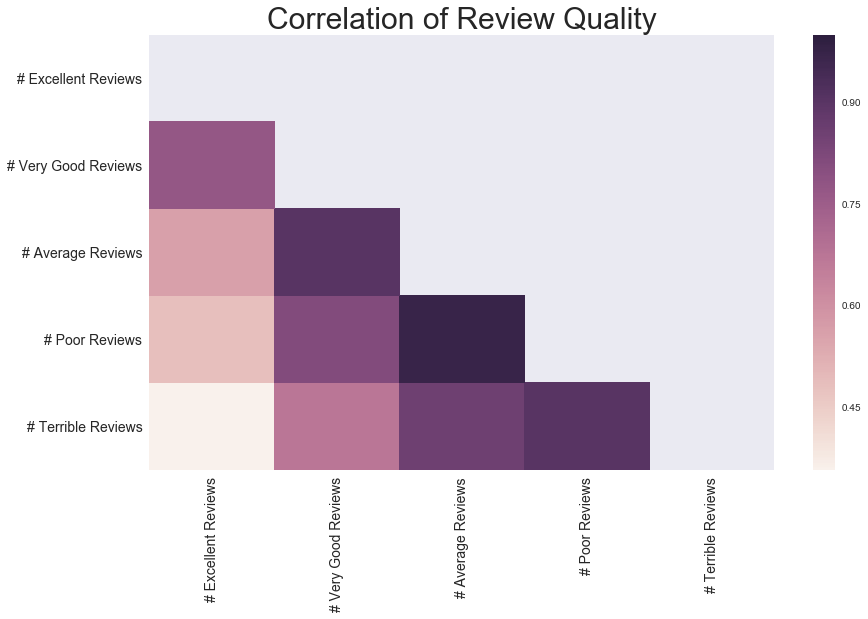

In [210]:
corrs = df_sub.corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(14,8))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corrs, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

plt.title("Correlation of Review Quality", fontsize= 30)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

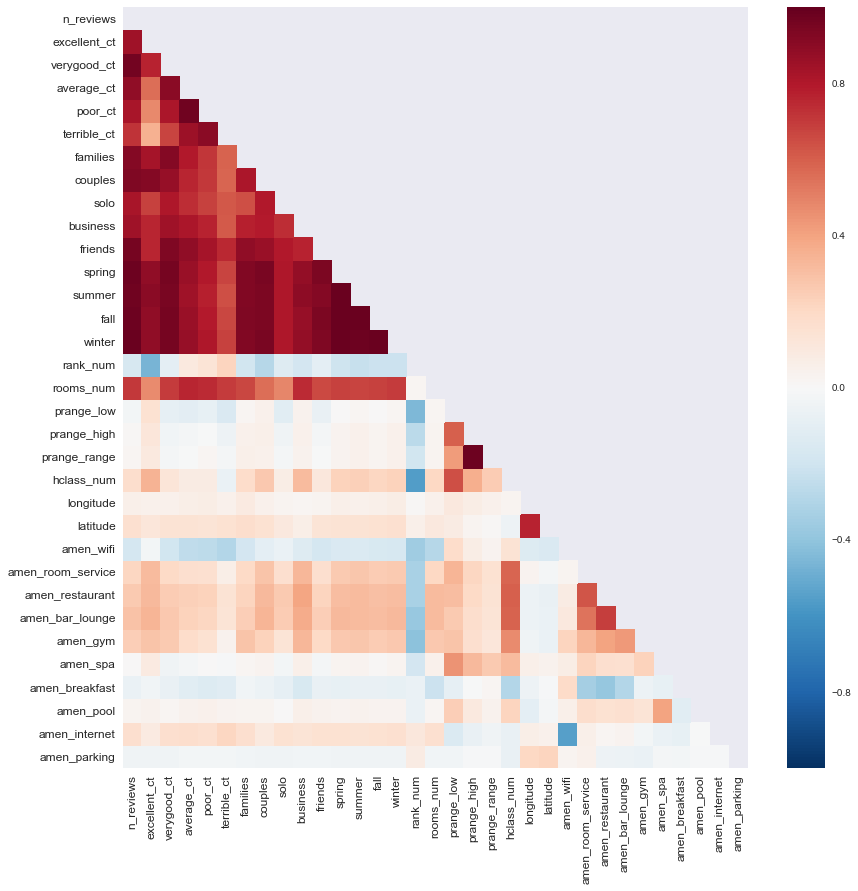

In [211]:
corrs = df.corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(14,14))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corrs, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12, rotation=90)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12, rotation=0)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

In [212]:
df.corr()

,n_reviews,excellent_ct,verygood_ct,average_ct,poor_ct,terrible_ct,families,couples,solo,business,...,amen_wifi,amen_room_service,amen_restaurant,amen_bar_lounge,amen_gym,amen_spa,amen_breakfast,amen_pool,amen_internet,amen_parking
n_reviews,1.000000,0.848525,0.962677,0.885185,0.823423,0.725376,0.915686,0.934479,0.823449,0.845903,...,-0.173621,0.218039,0.265306,0.295969,0.242831,0.002251,-0.065492,0.027509,0.165473,-0.040886
excellent_ct,0.848525,1.000000,0.772737,0.561950,0.484349,0.357194,0.832851,0.916443,0.684492,0.759651,...,-0.031040,0.319504,0.323804,0.342043,0.284127,0.092638,-0.032918,0.040312,0.088192,-0.040512
verygood_ct,0.962677,0.772737,1.000000,0.902142,0.815889,0.675321,0.915767,0.870994,0.809323,0.848481,...,-0.189725,0.197361,0.255413,0.273394,0.258329,-0.046172,-0.076084,0.020021,0.167973,-0.039327
average_ct,0.885185,0.561950,0.902142,1.000000,0.974662,0.859367,0.797224,0.762286,0.737356,0.817052,...,-0.254360,0.169613,0.234558,0.229879,0.186172,-0.020529,-0.116649,0.042579,0.172750,-0.030429
poor_ct,0.823423,0.484349,0.815889,0.974662,1.000000,0.904660,0.718285,0.705515,0.687373,0.771592,...,-0.259384,0.159871,0.228115,0.216610,0.155664,0.005827,-0.133083,0.048361,0.159185,-0.025402
terrible_ct,0.725376,0.357194,0.675321,0.859367,0.904660,1.000000,0.588858,0.582010,0.621455,0.611863,...,-0.294392,0.068569,0.145599,0.135015,0.043669,-0.015475,-0.119448,0.032911,0.215674,-0.024231
families,0.915686,0.832851,0.915767,0.797224,0.718285,0.588858,1.000000,0.814466,0.647194,0.779094,...,-0.181749,0.203003,0.221882,0.245987,0.284940,0.022175,-0.031953,0.023477,0.169357,-0.034628
couples,0.934479,0.916443,0.870994,0.762286,0.705515,0.582010,0.814466,1.000000,0.800911,0.795542,...,-0.093847,0.284127,0.320731,0.336235,0.231270,0.037654,-0.054758,0.025391,0.100499,-0.040896
solo,0.823449,0.684492,0.809323,0.737356,0.687373,0.621455,0.647194,0.800911,1.000000,0.737673,...,-0.070165,0.166417,0.259180,0.256788,0.133566,-0.031039,-0.090494,0.000597,0.156015,-0.043546
business,0.845903,0.759651,0.848481,0.817052,0.771592,0.611863,0.779094,0.795542,0.737673,1.000000,...,-0.129998,0.328282,0.397458,0.373773,0.333070,0.057116,-0.158391,0.061512,0.139096,-0.037484


In [213]:
rank_corr_df = df.corr()['rank_num']

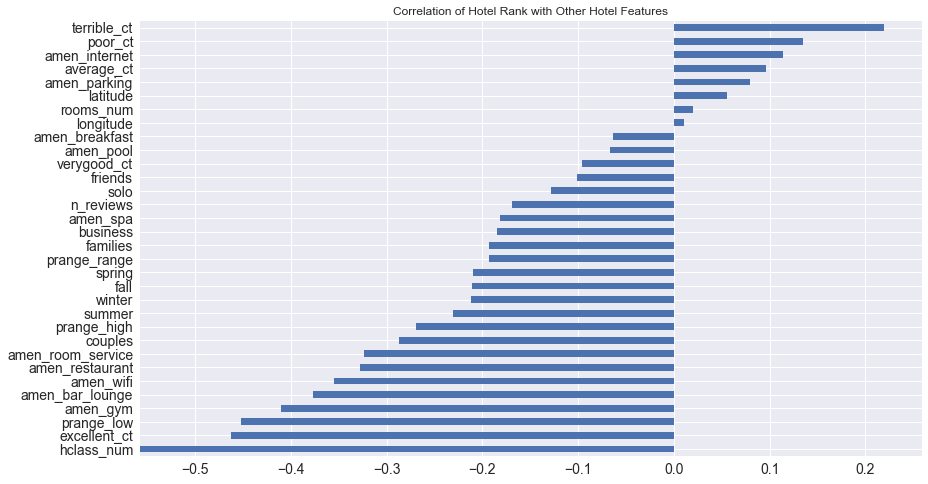

In [214]:
title = "Correlation of Hotel Rank with Other Hotel Features"
rank_corr_df[rank_corr_df.index != 'rank_num'].sort_values().plot(kind="barh", title=title, figsize=(14,8), fontsize=14)
plt.show()

In [215]:
df.columns

Index([             u'name',         u'n_reviews',           u'st_addr',
                    u'city',             u'state',            u'zip_cd',
            u'excellent_ct',       u'verygood_ct',        u'average_ct',
                 u'poor_ct',       u'terrible_ct',          u'families',
                 u'couples',              u'solo',          u'business',
                 u'friends',            u'spring',            u'summer',
                    u'fall',            u'winter',       u'description',
                u'rank_num',         u'rooms_num',        u'prange_low',
             u'prange_high',      u'prange_range',        u'hclass_num',
                   u'zip_5',         u'full_addr',         u'longitude',
                u'latitude',        u'rank_group',         u'amen_wifi',
       u'amen_room_service',   u'amen_restaurant',   u'amen_bar_lounge',
                u'amen_gym',          u'amen_spa',    u'amen_breakfast',
               u'amen_pool',     u'amen_internet', 

In [216]:
continuous = df[['n_reviews','excellent_ct','verygood_ct','average_ct','poor_ct','terrible_ct','families',
                'couples','solo','business','friends','spring','summer','fall','winter','rooms_num',
                'prange_low','prange_high','prange_range','rank_num']]

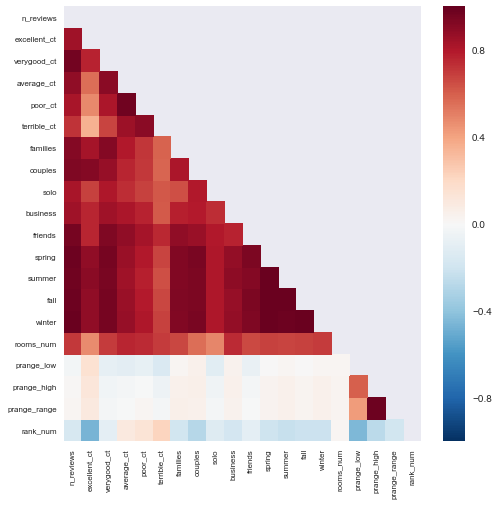

In [217]:
corrs = continuous.corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(8,8))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corrs, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=8, rotation=90)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=8, rotation=0)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

In [218]:
rank_corr_cont_df = continuous.corr()['rank_num']

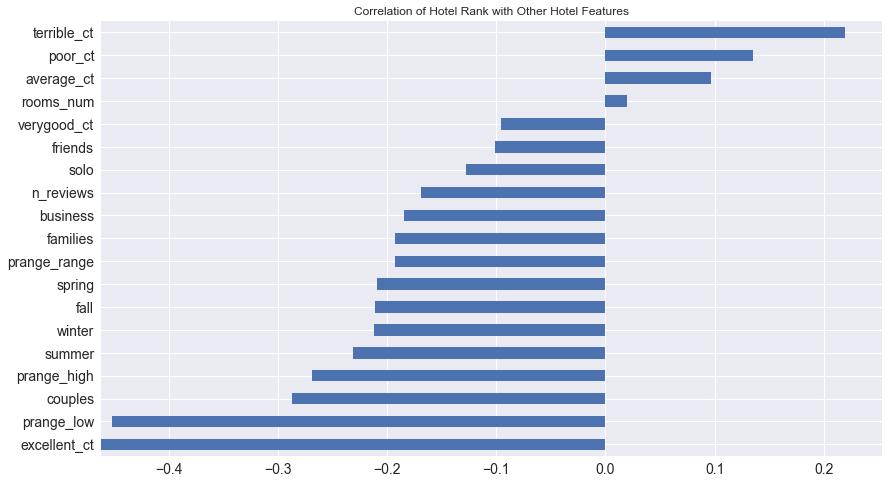

In [219]:
title = "Correlation of Hotel Rank with Other Hotel Features"
rank_corr_cont_df[rank_corr_cont_df.index != 'rank_num'].sort_values().plot(kind="barh", title=title, figsize=(14,8), fontsize=14)
plt.show()

In [220]:
categorical = df[['zip_5','hclass_num',
                 'amen_wifi','amen_room_service','amen_restaurant','amen_bar_lounge',
              'amen_gym','amen_spa','amen_breakfast','amen_pool','amen_internet','amen_parking']]

In [221]:
qual_cols = categorical.columns.tolist()

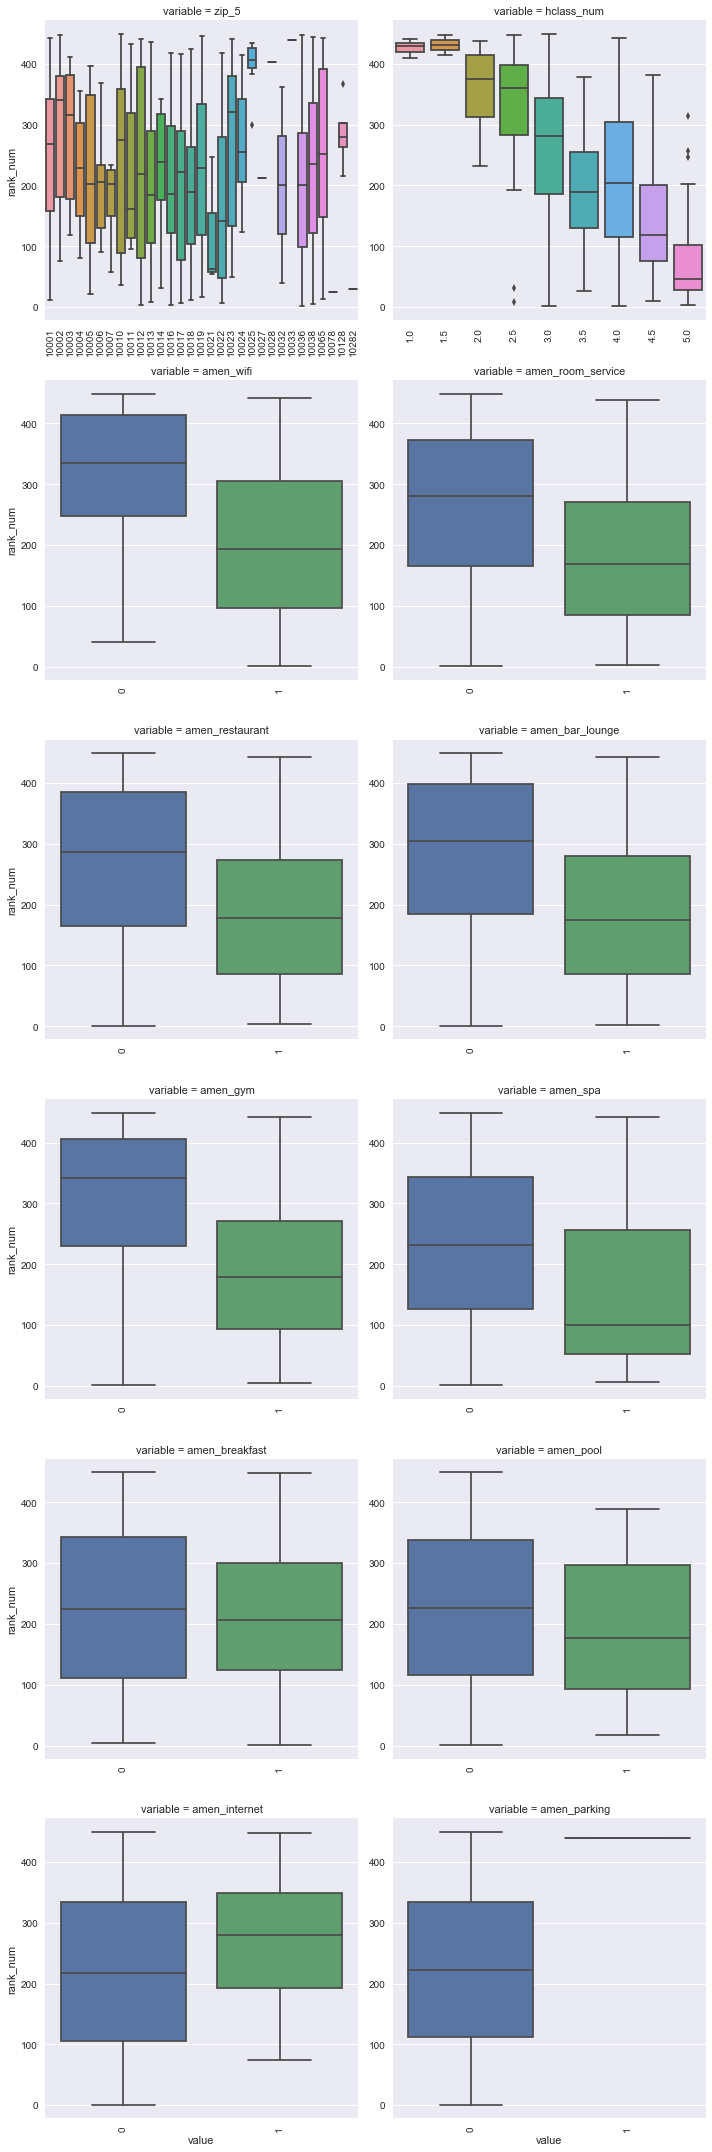

In [222]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
    
f = pd.melt(df, id_vars=['rank_num'], value_vars=qual_cols)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "rank_num")

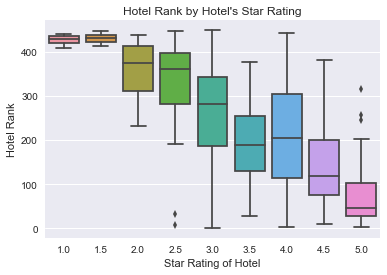

In [223]:
sns.boxplot(x=df.hclass_num, y=df.rank_num)
plt.title("Hotel Rank by Hotel's Star Rating")
plt.ylabel("Hotel Rank");
plt.xlabel("Star Rating of Hotel")
plt.show()

In [224]:
df.columns

Index([             u'name',         u'n_reviews',           u'st_addr',
                    u'city',             u'state',            u'zip_cd',
            u'excellent_ct',       u'verygood_ct',        u'average_ct',
                 u'poor_ct',       u'terrible_ct',          u'families',
                 u'couples',              u'solo',          u'business',
                 u'friends',            u'spring',            u'summer',
                    u'fall',            u'winter',       u'description',
                u'rank_num',         u'rooms_num',        u'prange_low',
             u'prange_high',      u'prange_range',        u'hclass_num',
                   u'zip_5',         u'full_addr',         u'longitude',
                u'latitude',        u'rank_group',         u'amen_wifi',
       u'amen_room_service',   u'amen_restaurant',   u'amen_bar_lounge',
                u'amen_gym',          u'amen_spa',    u'amen_breakfast',
               u'amen_pool',     u'amen_internet', 

In [225]:
df[(df.hclass_num != 1.0) & (df.hclass_num != 1.5)].groupby('hclass_num')['rooms_num'].describe()

hclass_num       
2.0         count      16.000000
            mean       86.750000
            std        85.692084
            min        25.000000
            25%        40.750000
            50%        55.000000
            75%        85.500000
            max       375.000000
2.5         count      26.000000
            mean      148.615385
            std       324.605493
            min         4.000000
            25%        46.250000
            50%        75.500000
            75%       114.000000
            max      1705.000000
3.0         count      87.000000
            mean      135.367816
            std       102.023152
            min        15.000000
            25%        70.000000
            50%       124.000000
            75%       180.500000
            max       618.000000
3.5         count      59.000000
            mean      223.949153
            std       143.690211
            min        27.000000
            25%       126.500000
            50%       211

In [226]:
df[(df.hclass_num != 1.0) & (df.hclass_num != 1.5)].groupby('hclass_num')['n_reviews'].describe()

hclass_num       
2.0         count       16.000000
            mean       592.562500
            std        465.582498
            min          2.000000
            25%        233.750000
            50%        624.000000
            75%        724.500000
            max       1505.000000
2.5         count       26.000000
            mean       915.538462
            std        935.694960
            min          8.000000
            25%        340.000000
            50%        577.000000
            75%       1233.250000
            max       3770.000000
3.0         count       87.000000
            mean      1364.574713
            std       1251.973091
            min          1.000000
            25%        526.500000
            50%       1089.000000
            75%       1814.500000
            max       6614.000000
3.5         count       61.000000
            mean      1810.475410
            std       1714.736565
            min         58.000000
            25%        776.000

hclass_num
2.0    Axes(0.125,0.125;0.775x0.755)
2.5    Axes(0.125,0.125;0.775x0.755)
3.0    Axes(0.125,0.125;0.775x0.755)
3.5    Axes(0.125,0.125;0.775x0.755)
4.0    Axes(0.125,0.125;0.775x0.755)
4.5    Axes(0.125,0.125;0.775x0.755)
5.0    Axes(0.125,0.125;0.775x0.755)
Name: prange_low, dtype: object

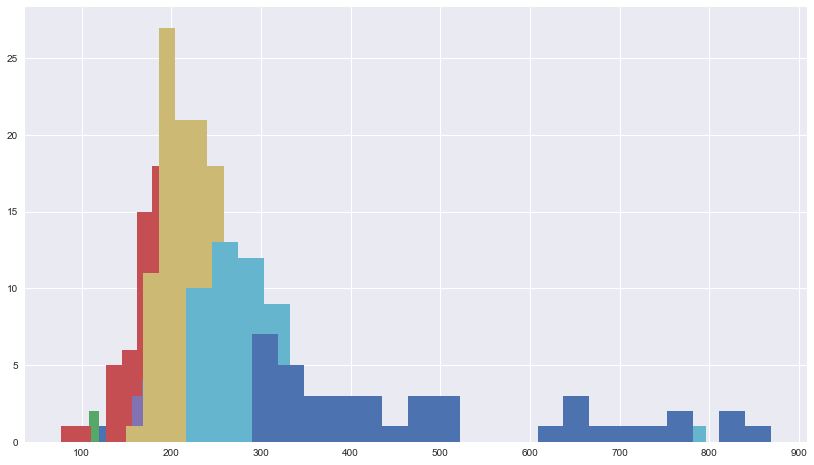

In [227]:
df[(df.hclass_num != 1.0) & (df.hclass_num != 1.5)].groupby('hclass_num')['prange_low'].hist(bins=20, figsize=(14,8))
#plt.figure(figsize=(14,8))

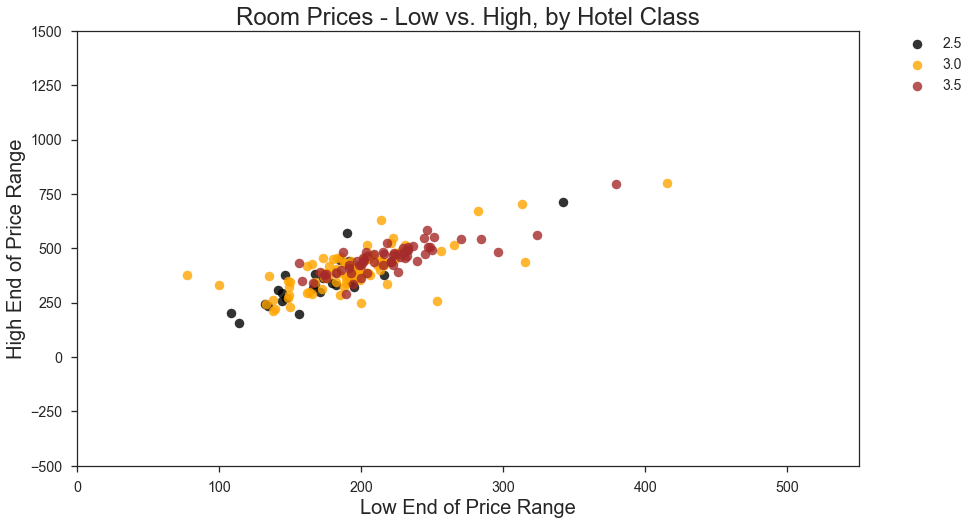

In [228]:
sns.set_context("talk", font_scale=1.1)
sns.set_style("ticks")

plt.figure(figsize=(14,8))
plt.title('Room Prices - Low vs. High, by Hotel Class', fontsize=24)
plt.xlabel('Low End of Price Range', fontsize=20)
plt.ylabel('High End of Price Range', fontsize=20)
#plt.ylim(-500,4000)
plt.xlim(0,550)
plt.ylim(-500,1500)

#plt.scatter(df[df.hclass_num == 1.0].prange_low,df[df.hclass_num == 1.0].prange_high,color='red',label='1.0',alpha=0.8)
#plt.scatter(df[df.hclass_num == 1.5].prange_low,df[df.hclass_num == 1.5].prange_high,color='blue',label='1.5',alpha=0.8)
#plt.scatter(df[df.hclass_num == 2.0].prange_low,df[df.hclass_num == 2.0].prange_high,color='green',label='2.0',alpha=0.8)
plt.scatter(df[df.hclass_num == 2.5].prange_low,df[df.hclass_num == 2.5].prange_high,color='black',label='2.5',alpha=0.8)
plt.scatter(df[df.hclass_num == 3.0].prange_low,df[df.hclass_num == 3.0].prange_high,color='orange',label='3.0',alpha=0.8)
plt.scatter(df[df.hclass_num == 3.5].prange_low,df[df.hclass_num == 3.5].prange_high,color='brown',label='3.5',alpha=0.8)
#plt.scatter(df[df.hclass_num == 4.0].prange_low,df[df.hclass_num == 4.0].prange_high,color='yellow',label='4.0',alpha=0.8)
#plt.scatter(df[df.hclass_num == 4.5].prange_low,df[df.hclass_num == 4.5].prange_high,color='sandybrown',label='4.5',alpha=0.8)
#plt.scatter(df[df.hclass_num == 5.0].prange_low,df[df.hclass_num == 5.0].prange_high,color='c',label='5.0',alpha=0.8)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=14)

plt.show()

In [229]:
df[df.n_reviews > 15000]['name']

153    Row NYC Hotel
Name: name, dtype: object

In [230]:
df.columns

Index([             u'name',         u'n_reviews',           u'st_addr',
                    u'city',             u'state',            u'zip_cd',
            u'excellent_ct',       u'verygood_ct',        u'average_ct',
                 u'poor_ct',       u'terrible_ct',          u'families',
                 u'couples',              u'solo',          u'business',
                 u'friends',            u'spring',            u'summer',
                    u'fall',            u'winter',       u'description',
                u'rank_num',         u'rooms_num',        u'prange_low',
             u'prange_high',      u'prange_range',        u'hclass_num',
                   u'zip_5',         u'full_addr',         u'longitude',
                u'latitude',        u'rank_group',         u'amen_wifi',
       u'amen_room_service',   u'amen_restaurant',   u'amen_bar_lounge',
                u'amen_gym',          u'amen_spa',    u'amen_breakfast',
               u'amen_pool',     u'amen_internet', 

In [231]:
df[['name','rank_num','hclass_num','prange_low','prange_high']].to_csv('hotel_names_and_prices.csv')

In [232]:
#SAVE HOTEL-LEVEL DATA TO PICKLE FILE
df.to_pickle('my_df.pickle')

In [233]:
df2 = pd.read_pickle('my_df.pickle')

In [234]:
ranks_list = df2.rank_num.unique().tolist()
ranks_list.sort()
ranks_list

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 129.0,
 130.0,
 131.0,
 132.0,
 133.0,
 134.0,
 135.0,
 136.0,
 137.0,
 138.0,
 139

In [235]:
df2.rank_num.unique().size

446

In [236]:
#Ranks missing: 432, 421, 392 (shift values so there are no gaps)
def shift_values(orig_val):
    if orig_val <= 391:
        new_val = orig_val
    elif (orig_val > 391) & (orig_val <= 420):
        new_val = orig_val - 1
    elif (orig_val > 421) & (orig_val <= 431):
        new_val = orig_val - 2
    elif orig_val > 432:
        new_val = orig_val - 3
    return new_val

In [237]:
df2['rank_num'] = df2.rank_num.apply(lambda x: shift_values(x))

In [238]:
ranks_list_mdfd = df2.rank_num.unique().tolist()
ranks_list_mdfd.sort()
ranks_list_mdfd

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 129.0,
 130.0,
 131.0,
 132.0,
 133.0,
 134.0,
 135.0,
 136.0,
 137.0,
 138.0,
 139

In [240]:
df2['top30'] = df2.rank_num.apply(lambda x: 1 if x <= 30 else 0)

In [241]:
df2.top30.value_counts()

0    416
1     30
Name: top30, dtype: int64

In [242]:
df2['n_english_reviews'] = df2.spring + df2.summer + df2.fall + df2.winter

In [243]:
df2['pct_english_reviews'] = df2.n_english_reviews / df2.n_reviews

In [244]:
count_cols = {'rating_cts': ['excellent_ct','verygood_ct','average_ct','poor_ct','terrible_ct'],
             'travel_type_cts': ['families','couples','solo','business','friends'],
             'season_cts': ['spring','summer','fall','winter']}

In [245]:
count_cols.items()

[('rating_cts',
  ['excellent_ct', 'verygood_ct', 'average_ct', 'poor_ct', 'terrible_ct']),
 ('travel_type_cts', ['families', 'couples', 'solo', 'business', 'friends']),
 ('season_cts', ['spring', 'summer', 'fall', 'winter'])]

In [246]:
for item in count_cols.items():
    for count_col in item[1]:
        print count_col

excellent_ct
verygood_ct
average_ct
poor_ct
terrible_ct
families
couples
solo
business
friends
spring
summer
fall
winter


In [247]:
for item in count_cols.items():
    #dynamic string to be used for naming column with total of category counts
    item_ct = item[0].split('_')[0] + '_ct'
    df2[item_ct] = 0.
    #dynamic string to be used for naming column with total of category percentages
    item_pct = item[0].split('_')[0] + '_pct'
    df2[item_pct] = 0.
    for cc in item[1]:
        cc_pct = cc.split('_')[0] + '_pct'
        df2[cc_pct] = df2[cc] / df2.n_english_reviews
        #df2[item_ct] += df2[cc]
        #df2[item_pct] += df2[cc_pct]

df2['travel_type_pct_unk'] = 1. - (df2.families_pct + df2.couples_pct + df2.solo_pct + df2.business_pct + df2.friends_pct)

In [248]:
df2[['name','n_reviews','n_english_reviews','pct_english_reviews']].head()

,name,n_reviews,n_english_reviews,pct_english_reviews
0,Loews Regency New York Hotel,1355,1220.0,0.900369
1,The Towers of the Waldorf Astoria - TEMPORARIL...,2016,1830.0,0.907738
2,Langham Place New York Fifth Avenue,2065,1743.0,0.844068
3,The Mark,687,589.0,0.857351
4,The St. Regis New York,633,573.0,0.905213


In [249]:
df2[['excellent_pct','verygood_pct','average_pct','poor_pct','terrible_pct']].head()

,excellent_pct,verygood_pct,average_pct,poor_pct,terrible_pct
0,0.780328,0.132787,0.050820,0.022131,0.013934
1,0.754645,0.133880,0.058470,0.037705,0.015301
2,0.812966,0.116466,0.041308,0.018933,0.010327
3,0.787776,0.147708,0.040747,0.013582,0.010187
4,0.781850,0.122164,0.059337,0.020942,0.015707


In [250]:
df2[['spring_pct','summer_pct','fall_pct','winter_pct']].head()

,spring_pct,summer_pct,fall_pct,winter_pct
0,0.258197,0.283607,0.223770,0.234426
1,0.229508,0.288525,0.208743,0.273224
2,0.247849,0.259897,0.238095,0.254159
3,0.193548,0.305603,0.264856,0.235993
4,0.216405,0.244328,0.246073,0.293194


In [251]:
df2[['travel_type_pct_unk','families_pct','couples_pct','solo_pct','business_pct','friends_pct']].head()

,travel_type_pct_unk,families_pct,couples_pct,solo_pct,business_pct,friends_pct
0,0.049180,0.315574,0.303279,0.036066,0.211475,0.084426
1,0.049180,0.345902,0.355191,0.036066,0.133333,0.080328
2,0.065404,0.256454,0.370052,0.037866,0.206540,0.063683
3,0.071307,0.195246,0.398981,0.089983,0.191851,0.052632
4,0.064572,0.225131,0.431065,0.045375,0.178010,0.055846


In [252]:
df2_miss = df2.isnull().sum().sort_values(ascending=False)
df2_miss[df2_miss > 0]

hclass_num      28
prange_range    22
prange_high     22
prange_low      22
rooms_num        6
dtype: int64

In [253]:
df2.loc[df2['rooms_num'].isnull()]

,name,n_reviews,st_addr,city,state,zip_cd,excellent_ct,verygood_ct,average_ct,poor_ct,...,solo_pct,business_pct,friends_pct,season_ct,season_pct,spring_pct,summer_pct,fall_pct,winter_pct,travel_type_pct_unk
99,National at Park Towers,2,315 West 57th Street,New York City,NY,10019-3158,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.500000,0.000000,0.500000,0.000000,0.000000
100,Third Ave House,4,215 E 81st St,New York City,NY,10028-2625,1.0,0.0,0.0,1.0,...,0.666667,0.666667,0.000000,0.0,0.0,0.000000,0.333333,0.333333,0.333333,-0.333333
307,Hilton Garden Inn New York/Midtown Park Ave,926,45 E 33rd St,New York City,NY,10016-5336,409.0,234.0,53.0,28.0,...,0.074124,0.230458,0.106469,0.0,0.0,0.222372,0.195418,0.258760,0.323450,0.033693
315,Hilton Garden Inn New York/Manhattan-Midtown East,1128,206 E 52nd St,New York City,NY,10022-6201,514.0,289.0,92.0,34.0,...,0.080713,0.230608,0.081761,0.0,0.0,0.208595,0.273585,0.268344,0.249476,0.054507
355,Executive Hotel LeSoleil,616,38 W 36th St,New York City,NY,10018-8078,313.0,129.0,39.0,11.0,...,0.070140,0.166333,0.078156,0.0,0.0,0.238477,0.142285,0.308617,0.310621,0.062124
380,Hotel Indigo Lower East Side New York,500,171 Ludlow Street,New York City,NY,10002-1501,293.0,99.0,24.0,10.0,...,0.097222,0.173611,0.129630,0.0,0.0,0.300926,0.189815,0.219907,0.289352,0.048611


In [254]:
from fancyimpute import KNN

In [255]:
cols_for_impute = ['n_reviews','rank_num','rooms_num','prange_low','prange_high',
                    'prange_range','hclass_num','amen_wifi','amen_room_service','amen_restaurant',
                    'amen_bar_lounge','amen_gym','amen_spa','amen_breakfast','amen_pool','amen_internet',
                    'amen_parking','n_english_reviews']
df2_for_impute = df2[cols_for_impute]
array_filled_knn = KNN(k=5).complete(df2_for_impute)

Imputing row 1/446 with 0 missing, elapsed time: 0.052
Imputing row 101/446 with 5 missing, elapsed time: 0.056
Imputing row 201/446 with 0 missing, elapsed time: 0.057
Imputing row 301/446 with 0 missing, elapsed time: 0.057
Imputing row 401/446 with 0 missing, elapsed time: 0.057


In [256]:
df2_filled_knn = pd.DataFrame(array_filled_knn, columns=cols_for_impute)

In [257]:
df2_filled_knn.shape

(446, 18)

In [258]:
df2_filled_knn.isnull().sum()

n_reviews            0
rank_num             0
rooms_num            0
prange_low           0
prange_high          0
prange_range         0
hclass_num           0
amen_wifi            0
amen_room_service    0
amen_restaurant      0
amen_bar_lounge      0
amen_gym             0
amen_spa             0
amen_breakfast       0
amen_pool            0
amen_internet        0
amen_parking         0
n_english_reviews    0
dtype: int64

In [259]:
df2.drop(cols_for_impute, axis=1, inplace=True)

In [260]:
df2.columns

Index([               u'name',             u'st_addr',                u'city',
                     u'state',              u'zip_cd',        u'excellent_ct',
               u'verygood_ct',          u'average_ct',             u'poor_ct',
               u'terrible_ct',            u'families',             u'couples',
                      u'solo',            u'business',             u'friends',
                    u'spring',              u'summer',                u'fall',
                    u'winter',         u'description',               u'zip_5',
                 u'full_addr',           u'longitude',            u'latitude',
                u'rank_group',               u'top30', u'pct_english_reviews',
                 u'rating_ct',          u'rating_pct',       u'excellent_pct',
              u'verygood_pct',         u'average_pct',            u'poor_pct',
              u'terrible_pct',           u'travel_ct',          u'travel_pct',
              u'families_pct',         u'couples_pct

In [261]:
df2_filledin = pd.concat([df2,df2_filled_knn],axis=1)

In [262]:
print df2.shape, df2_filled_knn.shape, df2_filledin.shape

(446, 48) (446, 18) (446, 66)


In [263]:
df2_filledin.hclass_num.unique()

array([ 3.5       ,  5.        ,  4.5       ,  4.        ,  3.        ,
        2.        ,  3.1614507 ,  2.5       ,  3.24511982,  3.62087949,
        2.55732466,  3.06886431,  1.5       ,  2.51467582,  3.90299289,
        3.23112809,  1.        ,  2.7511178 ,  2.58378577,  2.81227851,
        3.71388554,  3.56211855,  3.23007926,  3.35065197,  3.86311923,
        2.97473412,  3.47705073,  3.46393902,  3.4477837 ,  3.79253053,
        3.79736988,  3.30536893,  2.95172379,  2.92417048,  3.148012  ,
        2.72941823,  2.93045089])

In [264]:
df2_filledin['hclass_num'] = df2_filledin.hclass_num.apply(lambda x: round(x * 2) / 2)

In [265]:
df2_filledin.hclass_num.unique()

array([ 3.5,  5. ,  4.5,  4. ,  3. ,  2. ,  2.5,  1.5,  1. ])

In [266]:
#convert hotel class values to dummies
df2_filledin = pd.get_dummies(df2_filledin, columns=['hclass_num'])

In [267]:
#convert zip5 values to dummies
df2_filledin = pd.get_dummies(df2_filledin, columns=['zip_5'])

In [268]:
df2 = df2_filledin

In [269]:
df2.drop(['rating_pct','season_pct','travel_pct'],axis=1,inplace=True)

In [270]:
df2.shape

(446, 101)

In [271]:
df2.to_pickle('df_446.pickle')